# Recreating @dgleeson's implementation which can be found [here](https://public.tableau.com/profile/donovangleeson#!/vizhome/MakeoverMonday-Week30/OffensiveContribution).

In [1]:
import math
import numpy as np 
import pandas as pd
from PIL import Image

import matplotlib
import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_pgf import FigureCanvasPgf
matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)

from matplotlib import rc
#rc('text',usetex=True)
#rc('text.latex', preamble=r'\usepackage{xcolor}')
rc('pgf', preamble=r'\usepackage{xcolor}', rcfonts=False)

import matplotlib.pyplot as plt
import seaborn as sns

pd.options.mode.chained_assignment = None # surpress is copy warning


import os
import sys
module_path = os.path.abspath(os.path.join('../../z_assets/helpers'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pdf_helper

In [2]:
df = pd.read_csv('../Arsenal Player Stats 2018-19.csv')
df.head()

,Rank,Player,Nationality,Metric,Stat
0,1,Pierre-Emerick Aubameyang,Gabon,Appearances,36
1,2,Alex Iwobi,Nigeria,Appearances,35
2,2,Alexandre Lacazette,France,Appearances,35
3,4,Lucas Torreira,Uruguay,Appearances,34
4,5,Matteo Guendouzi,France,Appearances,33


In [3]:
print(df['Player'].unique())
arsenal = ['Pierre-Emerick Aubameyang', 'Alexandre Lacazette', 'Aaron Ramsey', 'Henrikh Mkhitaryan',
           'Alex Iwobi', 'Mesut Özil', 'Sead Kolasinac', 'Héctor Bellerín', 'Granit Xhaka', 'Laurent Koscielny',
           'Nacho Monreal', 'Ainsley Maitland-Niles', 'Lucas Torreira', 'Sokratis', 'Shkodran Mustafi',
           'Matteo Guendouzi', 'Mohamed Elneny'
          ]

df = df[df['Player'].isin(arsenal)]
print()
print(df['Player'].unique())

['Pierre-Emerick Aubameyang' 'Alex Iwobi' 'Alexandre Lacazette'
 'Lucas Torreira' 'Matteo Guendouzi' 'Bernd Leno' 'Shkodran Mustafi'
 'Granit Xhaka' 'Aaron Ramsey' 'Henrikh Mkhitaryan' 'Sokratis'
 'Mesut Özil' 'Sead Kolasinac' 'Nacho Monreal' 'Héctor Bellerín'
 'Laurent Koscielny' 'Ainsley Maitland-Niles' 'Stephan Lichtsteiner'
 'Rob Holding' 'Danny Welbeck' 'Mohamed Elneny' 'Petr Cech'
 'Eddie Nketiah' 'Denis Suárez' 'Konstantinos Mavropanos' 'Carl Jenkinson'
 'Joe Willock' 'Bukayo Saka']

['Pierre-Emerick Aubameyang' 'Alex Iwobi' 'Alexandre Lacazette'
 'Lucas Torreira' 'Matteo Guendouzi' 'Shkodran Mustafi' 'Granit Xhaka'
 'Aaron Ramsey' 'Henrikh Mkhitaryan' 'Sokratis' 'Mesut Özil'
 'Sead Kolasinac' 'Nacho Monreal' 'Héctor Bellerín' 'Laurent Koscielny'
 'Ainsley Maitland-Niles' 'Mohamed Elneny']


In [4]:
pt = pd.pivot_table(df, values='Stat', index=['Player'], columns=['Metric'])
pt.reset_index(inplace=True)
print(pt.columns)
pt.head()

Index(['Player', 'Appearances', 'Assists', 'Big Chances Missed', 'Clearances',
       'Clearances Off Line', 'Dispossessed', 'Fouls', 'Goals', 'High Claim',
       'Hit Woodwork', 'Minutes Played', 'Offsides', 'Own Goal', 'Passes',
       'Punches', 'Red Cards', 'Saves', 'Shots', 'Tackles', 'Touches',
       'Yellow Cards'],
      dtype='object', name='Metric')


Metric,Player,Appearances,Assists,Big Chances Missed,Clearances,Clearances Off Line,Dispossessed,Fouls,Goals,High Claim,...,Offsides,Own Goal,Passes,Punches,Red Cards,Saves,Shots,Tackles,Touches,Yellow Cards
0,Aaron Ramsey,28,6,2,3,0,27,21,4,0,...,4,0,773,0,0,0,33,34,1029,0
1,Ainsley Maitland-Niles,16,1,0,11,1,17,8,1,0,...,1,0,451,0,1,0,5,33,782,1
2,Alex Iwobi,35,6,3,10,0,56,8,3,0,...,2,0,951,0,0,0,35,28,1415,0
3,Alexandre Lacazette,35,8,13,29,0,61,51,13,0,...,24,0,771,0,0,0,81,35,1313,2
4,Granit Xhaka,29,2,1,54,0,17,45,4,0,...,1,0,2245,0,0,0,29,52,2784,10


In [5]:
team_goals = pt['Goals'].sum()
pt['SCORING PARTICIPATION RATE'] = (pt['Assists'] + pt['Goals']) /  team_goals


pt['NET POINTS PER GAME'] = (pt['Goals'] + pt['Assists'] - pt['Own Goal']) / (pt['Minutes Played'] / 90)
pt = pt.sort_values(by='NET POINTS PER GAME', ascending=False)

pt['GOALS SHOT EFFICIENCY'] = (pt['Goals'] / pt['Shots'])
pt['HIT WOODWORK SHOT EFFICIENCY'] = (pt['Hit Woodwork'] / pt['Shots']) + pt['GOALS SHOT EFFICIENCY']

In [6]:
def x_format_round(value):
    return round(value, 2)

def x_format_percent(value):
    return '{0:.0%}'.format(value)


def draw_label_on_bar(ax, df, x_column, sort_column, sort_direction, x_format_function, x_offset, y_offset):
    temp = df.sort_values(by=sort_column, ascending=sort_direction)
    
    count = 0
    for index, row in temp.iterrows():
        x = row[x_column]
        x_value = x_format_function(x)
        x_position = x + x_offset if x > abs(x_offset) else abs(x_offset)
        y_position = count + y_offset
        
        ax.text(x_position, y_position, str(x_value), color='white', fontweight='bold')
        count = count + 1

In [7]:
def set_axis_colors(ax, color):
    plt.setp(ax.spines.values(), color=color)
    plt.setp([ax.get_xticklines(), ax.get_yticklines()], color=color)
    
def draw_x_axis(ax, title):
    ax.set_xlabel(title)
    ax.xaxis.set_label_position('top') 
    ax.get_xaxis().set_ticks([])
    set_axis_colors(ax, '#cbcbcb')
    ax.spines['left'].set_color('#cbcbcb')

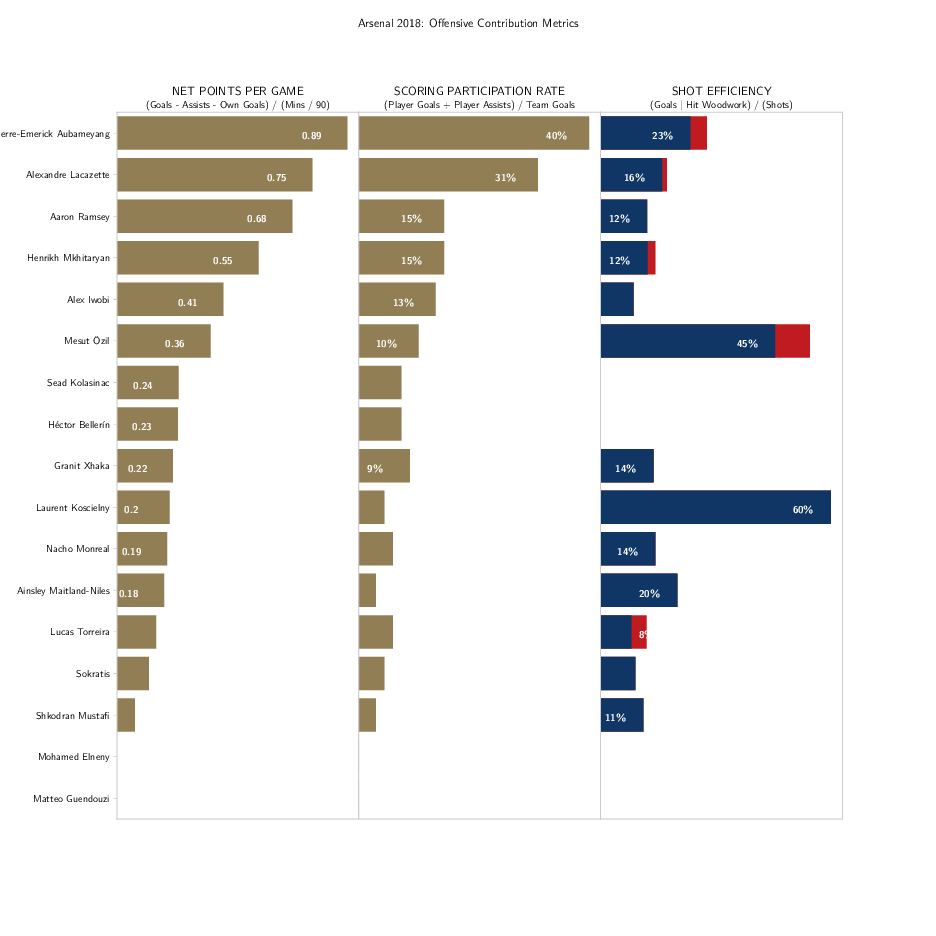

In [8]:
gs = gridspec.GridSpec(1, 3)
fig = plt.figure(figsize=(13, 13))
plt.subplots_adjust(wspace=0, hspace=0)
fig.suptitle('Arsenal 2018: Offensive Contribution Metrics')


ax = plt.subplot(gs[0, 0])
sns.barplot(ax=ax, x='NET POINTS PER GAME', y='Player', data=pt, color="#9c824a")
draw_label_on_bar(ax, pt, 'NET POINTS PER GAME', 'NET POINTS PER GAME', False, x_format_round, -0.175, 0.15)
ax.title.set_text('NET POINTS PER GAME')
draw_x_axis(ax, '(Goals - Assists - Own Goals) / (Mins / 90)')


ax = plt.subplot(gs[0, 1])
ax.get_yaxis().set_visible(False)
sns.barplot(ax=ax, x='SCORING PARTICIPATION RATE', y='Player', data=pt, color="#9c824a")
draw_label_on_bar(ax, pt, 'SCORING PARTICIPATION RATE', 'NET POINTS PER GAME', False, x_format_percent, -.075, 0.15)
ax.title.set_text('SCORING PARTICIPATION RATE')
draw_x_axis(ax, '(Player Goals + Player Assists) / Team Goals')


ax = plt.subplot(gs[0, 2])
ax.get_yaxis().set_visible(False)
sns.barplot(ax=ax, x='HIT WOODWORK SHOT EFFICIENCY', y='Player', data=pt, color="#db0007");
sns.barplot(ax=ax, x='GOALS SHOT EFFICIENCY', y='Player', data=pt, color="#023474");
draw_label_on_bar(ax, pt, 'GOALS SHOT EFFICIENCY', 'NET POINTS PER GAME', False, x_format_percent, -.1, 0.15)
ax.title.set_text('SHOT EFFICIENCY')
draw_x_axis(ax, '(Goals | Hit Woodwork) / (Shots)')


pdf_helper.save_and_show_pdf('Week30_Arsenal_Bargraph.pdf', fig, plt)